In [1]:
# Core libraries
import os
import numpy as np
import cv2

# Image processing and visualization
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras libraries
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, RandomRotation, RandomZoom, RandomContrast, RandomFlip
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# KaggleHub library
import kagglehub


In [2]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [3]:
data = []
labels = []

img_size = (224, 224)
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}


In [4]:
image_paths = list(paths.list_images('/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'))

for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    label = translate.get(label, label)

    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    data.append(img)
    labels.append(label)

print(f'Total Images Loaded: {len(data)}')


Total Images Loaded: 26179


In [5]:
print(f'Total Images Loaded: {len(data)}')
print(f'Total Labels Loaded: {len(labels)}')

Total Images Loaded: 26179
Total Labels Loaded: 26179


In [6]:
# Normalize pixel values to the range [0, 1]
data = np.array(data, dtype='float32') / 255.0

# Convert labels to a numpy array
labels = np.array(labels)

# Convert labels to numeric values
unique_labels = sorted(np.unique(labels))
label_dict = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_dict[label] for label in labels])

# Split the data into 80% training and 20% testing
(X_train, X_test, y_train, y_test) = train_test_split(
    data, numeric_labels, test_size=0.2, random_state=42, stratify=numeric_labels
)

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=len(unique_labels))
y_test = to_categorical(y_test, num_classes=len(unique_labels))

# Print the shapes of the training and testing sets
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (20943, 224, 224, 3) (20943, 10)
Testing set: (5236, 224, 224, 3) (5236, 10)


In [7]:

set_global_policy('mixed_float16')

In [8]:


def build_improved_model(input_shape=(224, 224, 3), num_classes=10):
    # Define inputs
    inputs = Input(shape=input_shape)

    # Stronger Data Augmentation
    x = RandomRotation(0.3)(inputs)  # Increase rotation
    x = RandomZoom(0.2)(x)  # Increase zoom
    x = RandomContrast(0.2)(x)  # Increase contrast
    x = RandomFlip(mode='horizontal_and_vertical')(x)  # Horizontal and vertical flip

    # Convolutional Block 1 - Reduce the number of filters
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=L2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.1)(x)  # Add light dropout after each block

    # Convolutional Block 2
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=L2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.2)(x)  # Gradually increase dropout rate

    # Convolutional Block 3
    x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=L2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.3)(x)

    # Convolutional Block 4
    x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=L2(0.0005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Reduce the number of Dense Layers and neurons
    x = Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Additional function for training with Early Stopping and learning rate reduction
def compile_and_train_with_callbacks(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=150):

    # Compile the model with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up callbacks
    checkpoint_callback = ModelCheckpoint(
      "best_model_6.keras",  # File name to save the model
      monitor="val_loss",  # Monitor validation loss
      save_best_only=True,  # Save only the best model
      mode="min",  # Save the model when val_loss is at its minimum
      verbose=1  # Print a message when saving the model
  )

    # Update the callbacks list to include ModelCheckpoint
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),
        checkpoint_callback  # Add ModelCheckpoint here
    ]

    # Train the model with the updated callbacks
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks  # Pass the updated list
    )

    return model, history

In [9]:
model = build_improved_model(input_shape=(224, 224, 3), num_classes=10)


trained_model, history = compile_and_train_with_callbacks(model, X_train, y_train, X_test, y_test)


Epoch 1/150
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2274 - loss: 2.8493
Epoch 1: val_loss improved from inf to 2.50244, saving model to best_model_7.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.2275 - loss: 2.8490 - val_accuracy: 0.2998 - val_loss: 2.5024 - learning_rate: 5.0000e-04
Epoch 2/150
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3619 - loss: 2.3247
Epoch 2: val_loss did not improve from 2.50244
655/655 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.3619 - loss: 2.3246 - val_accuracy: 0.2949 - val_loss: 2.6346 - learning_rate: 5.0000e-04
Epoch 3/150
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4124 - loss: 2.0912
Epoch 3: val_loss improved from 2.50244 to 2.29841, saving model to best_model_7.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4124 - loss: 2.0911 - val_accuracy: 0.3969 - val_loss: 2.2984 - learning_rate: 5.0000e-04
Epoch 4/150
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4684 - los

In [10]:
model.save('best_model_6.keras')

In [20]:
from tensorflow.keras.models import load_model


model = load_model('best_model_6.keras')


model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_6 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_3 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 28, 256)         │           1,0

 Total params: 1,583,332 (6.04 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 1,054,234 (4.02 MB)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def train_and_evaluate_model(input_shape=(224, 224, 3), num_classes=10,
                            X_train=None, y_train=None, X_val=None, y_val=None, X_test=None, y_test=None,
                            batch_size=32, epochs=50):
    # Call the previously defined improved model
    model = build_improved_model(input_shape=input_shape, num_classes=num_classes)

    # Compile the model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Save the best model
    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

    # Plot accuracy and loss curves
    plot_accuracy_loss(history)

    # Evaluate the model on the test set
    if X_test is not None and y_test is not None:
        evaluate_on_test_set(model, X_test, y_test, num_classes)

    return model, history

def plot_accuracy_loss(history):
    """Plot accuracy and loss curves for training and validation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy During Training')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss During Training')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print the best accuracy and loss values
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    best_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1

    print(f"Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_acc_epoch}")
    print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch {best_loss_epoch}")

    # Analyze the difference between training and validation accuracy (to detect overfitting)
    last_train_acc = history.history['accuracy'][-1]
    last_val_acc = history.history['val_accuracy'][-1]
    acc_diff = last_train_acc - last_val_acc

    print(f"\nDifference between Training and Validation Accuracy in the Last Epoch: {acc_diff:.4f}")
    if acc_diff > 0.1:
        print("Warning: Potential overfitting detected (difference greater than 0.1)")
    else:
        print("No strong indication of overfitting")

def evaluate_on_test_set(model, X_test, y_test, num_classes):
    """Evaluate the model on the test set and display the classification report and confusion matrix"""
    # Predict
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate overall accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nModel Accuracy on Test Set: {test_accuracy:.4f}")
    print(f"Model Loss on Test Set: {test_loss:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy for each class
    class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(range(num_classes)), y=class_accuracy)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy per Class')
    plt.ylim(0, 1)
    plt.show()

    # Review misclassified examples (optional)
    print("\nError Analysis:")
    error_indices = np.where(y_pred_classes != y_true_classes)[0]
    print(f"Number of Misclassified Examples: {len(error_indices)}")
    if len(error_indices) > 0:
        print(f"Most Common Errors:")
        error_pairs = [(y_true_classes[i], y_pred_classes[i]) for i in error_indices]
        from collections import Counter
        common_errors = Counter(error_pairs).most_common(5)
        for (true_class, pred_class), count in common_errors:
            print(f"   True Class: {true_class}, Predicted Class: {pred_class}, Count: {count}")

# Example of how to use the function (replace with actual data)
"""
# Call the function for training and evaluation
model, history = train_and_evaluate_model(
    input_shape=(224, 224, 3),
    num_classes=10,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    batch_size=32,
    epochs=50
)
"""

'\n# Call the function for training and evaluation\nmodel, history = train_and_evaluate_model(\n    input_shape=(224, 224, 3),\n    num_classes=10,\n    X_train=X_train,\n    y_train=y_train,\n    X_val=X_val,\n    y_val=y_val,\n    X_test=X_test,\n    y_test=y_test,\n    batch_size=32,\n    epochs=50\n)\n'

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Model Accuracy on Test Set: 0.8107
Model Loss on Test Set: 0.8050

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       422
           1       0.76      0.73      0.75       334
           2       0.81      0.90      0.85       620
           3       0.73      0.67      0.70       373
           4       0.88      0.74      0.81       973
           5       0.60      0.89      0.72       289
           6       0.80      0.74      0.77       525
           7       0.73      0.61      0.66       364
           8       0.86      0.96      0.91       964
           9       0.82      0.84      0.83       372

    accuracy                           0.81      5236
   macro avg       0.79      0.79      0.79      5236
weighted avg       0.82      0.81      0.81      5236



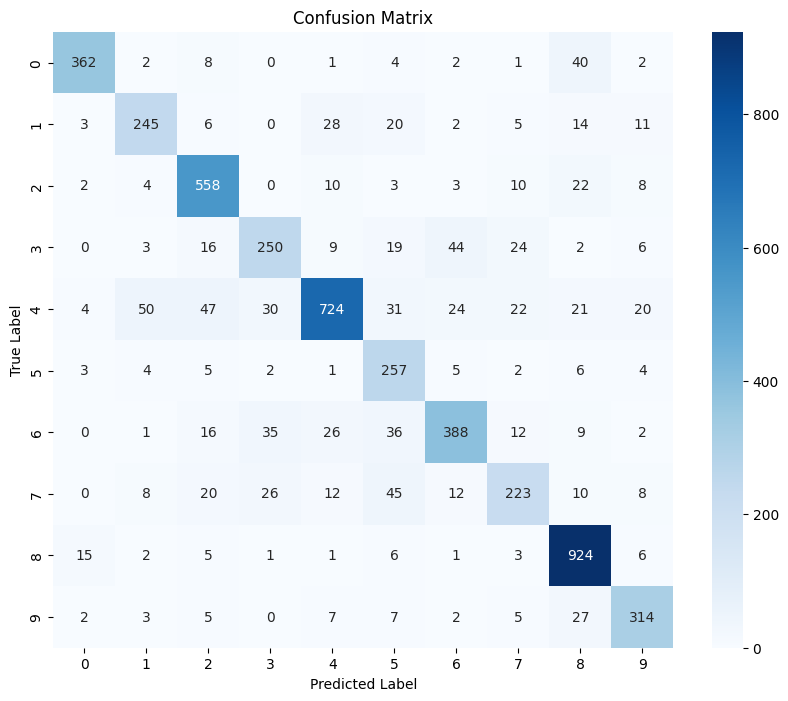

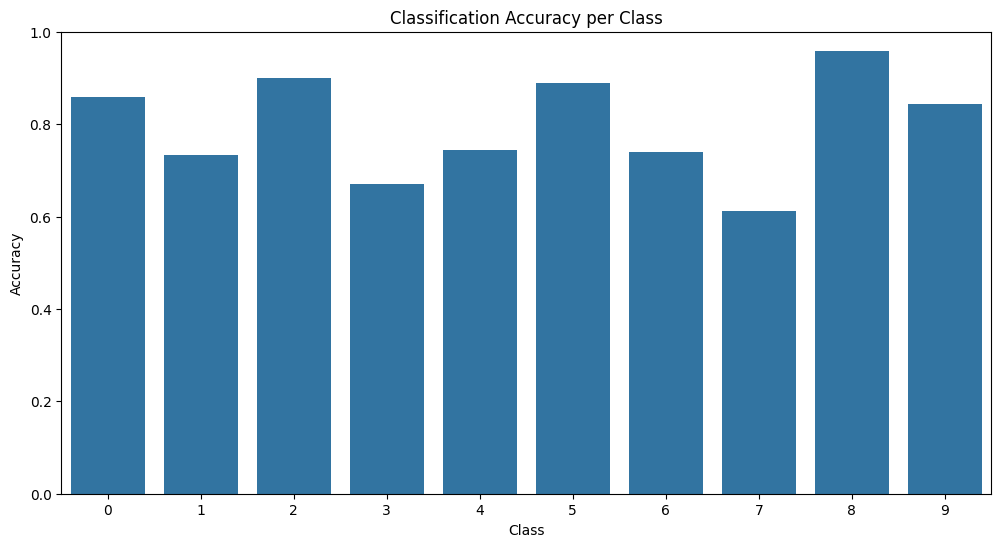


Error Analysis:
Number of Misclassified Examples: 991
Most Common Errors:
   True Class: 4, Predicted Class: 1, Count: 50
   True Class: 4, Predicted Class: 2, Count: 47
   True Class: 7, Predicted Class: 5, Count: 45
   True Class: 3, Predicted Class: 6, Count: 44
   True Class: 0, Predicted Class: 8, Count: 40


In [16]:
evaluate_on_test_set(model,X_test,y_test ,10)